[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/astrohack/blob/v0.5.10/docs/cassegrain_ray_tracing.ipynb)

![astrohack](_media/astrohack_logo.png)

# Cassegrain Ray Tracing tutorial

USER NEEDS TO PLAY AND SEE HOW THINGS CHANGE!

In [1]:
import os
try:
    import astrohack
    
    print('AstroHACK version', astrohack.__version__, 'already installed.')
except ImportError as e:
    print(e)
    print('Installing AstroHACK')
    
    os.system("pip install astrohack")
    
    import astrohack 
    print('astrohack version', astrohack.__version__, ' installed.')

AstroHACK version 0.5.11 already installed.


## Setting up

In [2]:
# Setting up file names and a folder to contain data
datafolder = 'vla-rt-data'
os.makedirs(datafolder, exist_ok=True)
vla_rt_filename = datafolder+'/VLA-rt.zarr'
plot_base_names = datafolder+'/vla-rt'

## Initiate Telescope parameters

Lorem

In [3]:
from astrohack import create_ray_tracing_telescope_parameter_dict

vla_pars = create_ray_tracing_telescope_parameter_dict(
    primary_diameter = 25,        # 25 meters for the VLA
    secondary_diameter = 2.5146,  # VLA's Secondary diameter
    focal_length = 9.0,           # VLA's focal length
    z_intercept = 3.140,          # Distance between the z intercept of the secondary and the point between the 2 foci
    foci_half_distance = 3.662,   # Half distance between the 2 foci
    inner_radius = 2.0,           # Inner blockage
    horn_diameter = 0.2,          # Horn diameter
    length_unit = 'm'             # Unit for the dimensions given
)

print()
for key, item in vla_pars.items():
    print(f'{key:20s} = {item}')
print()

[2025-02-11 14:17:37,393]     INFO   toolviper:  Module path: /export/home/figs/vdesouza/work/Holography-1022/astrohack/src/astrohack 

primary_diameter     = 25.0
secondary_diameter   = 2.5146
focal_length         = 9.0
z_intercept          = 3.14
foci_half_distance   = 3.662
inner_radius         = 2.0
horn_diameter        = 0.2
horn_position        = [0, 0, 1.6760000000000002]
horn_orientation     = [0, 0, 1]



## Run Ray tracing pipeline

lorem ipsum

In [4]:
%%time
from astrohack import cassegrain_ray_tracing_pipeline

rt_xds = cassegrain_ray_tracing_pipeline(
        output_xds_filename = vla_rt_filename,  # Name of the output XDS file
        telescope_parameters = vla_pars,        # Using previously defined dictionary with VLA parameters
        grid_size = 28,                         # Big enough to fit the primary of the VLA with some spare
        grid_resolution = 0.1,                  # Fine grained enough for most holographies
        grid_unit = 'm',                        # Unit for grid parameters
        x_pointing_offset = 5,                  # Pointing offset in the X direction
        y_pointing_offset = 4,                  # Pointing offset in the Y direction
        pointing_offset_unit = 'asec',          # Unit for pointing offset
        x_focus_offset = 0,                     # Secondary displacement in the X direction
        y_focus_offset = 0,                     # Secondary displacement in the Y direction
        z_focus_offset = 0,                     # Secondary displacement in the Z direction (regular focus offset)
        focus_offset_unit = 'mm',               # Unit for secondary displacements
        phase_offset = 0,                       # Simple additive offset for phases
        phase_unit = 'deg',                     # Unit for phase offset
        observing_wavelength = 1,               # Wavelength for the simulations
        wavelength_unit = 'cm',                 # Unit for the wavelength
        overwrite = True                        # Overwrite RT file on disk
)

[2025-02-11 14:17:37,406]     INFO   toolviper:  Module path: /export/home/figs/vdesouza/work/Holography-1022/astrohack/src/astrohack 
[2025-02-11 14:17:40,978]  WARNING   toolviper:  vla-rt-data/VLA-rt.zarr will be overwritten. 
CPU times: user 3.59 s, sys: 60.4 ms, total: 3.65 s
Wall time: 3.63 s


Inspect rt XDS

In [5]:
rt_xds

<xarray.Dataset> Size: 11MB
Dimensions:                        (points: 47816, xyz: 3, vxyz: 3, idx: 2,
                                    x: 283, y: 283)
Dimensions without coordinates: points, xyz, vxyz, idx, x, y
Data variables: (12/15)
    primary_points                 (points, xyz) float64 1MB -12.45 ... 4.336
    primary_normals                (points, vxyz) float64 1MB 0.5682 ... 0.8215
    image_indexes                  (points, idx) int64 765kB 16 130 ... 265 151
    x_axis                         (x) float64 2kB -14.05 -13.95 ... 14.05 14.15
    y_axis                         (y) float64 2kB -14.05 -13.95 ... 14.05 14.15
    primary_reflections            (points, vxyz) float64 1MB 0.9335 ... 0.3497
    ...                             ...
    secondary_normals              (points, vxyz) float64 1MB 0.524 ... 0.8508
    secondary_reflections          (points, vxyz) float64 1MB 0.1055 ... -0.9943
    distance_secondary_to_horn     (points) float64 383kB 7.083 7.083 ... 7.083
    horn_intercept                 (points, xyz) float64 1MB -0.002867 ... 1.676
    total_path                     (points) float64 383kB 19.62 19.62 ... 19.62
    phase                          (points) float64 383kB -0.1157 ... 0.2915
Attributes:
    image_size:            283
    npnt_1d:               47816
    telescope_parameters:  {'primary_diameter': 25.0, 'secondary_diameter': 2...
    input_parameters:      {'output_xds_filename': 'vla-rt-data/VLA-rt.zarr',...

## Plotting phases and other interesting products

[2025-02-11 14:17:41,066]     INFO   toolviper:  Module path: /export/home/figs/vdesouza/work/Holography-1022/astrohack/src/astrohack 


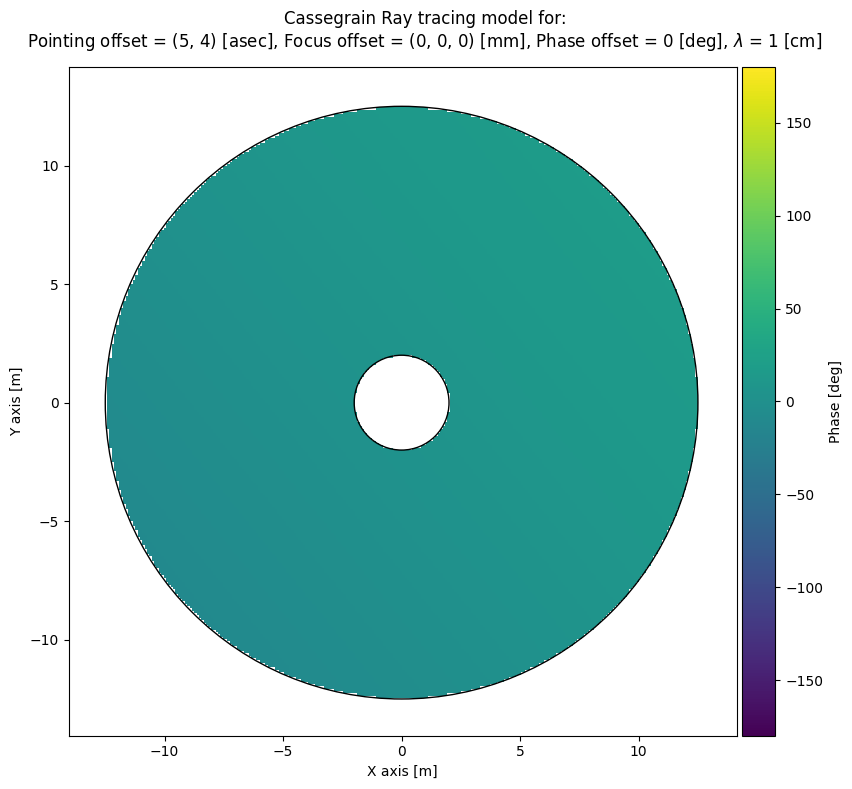

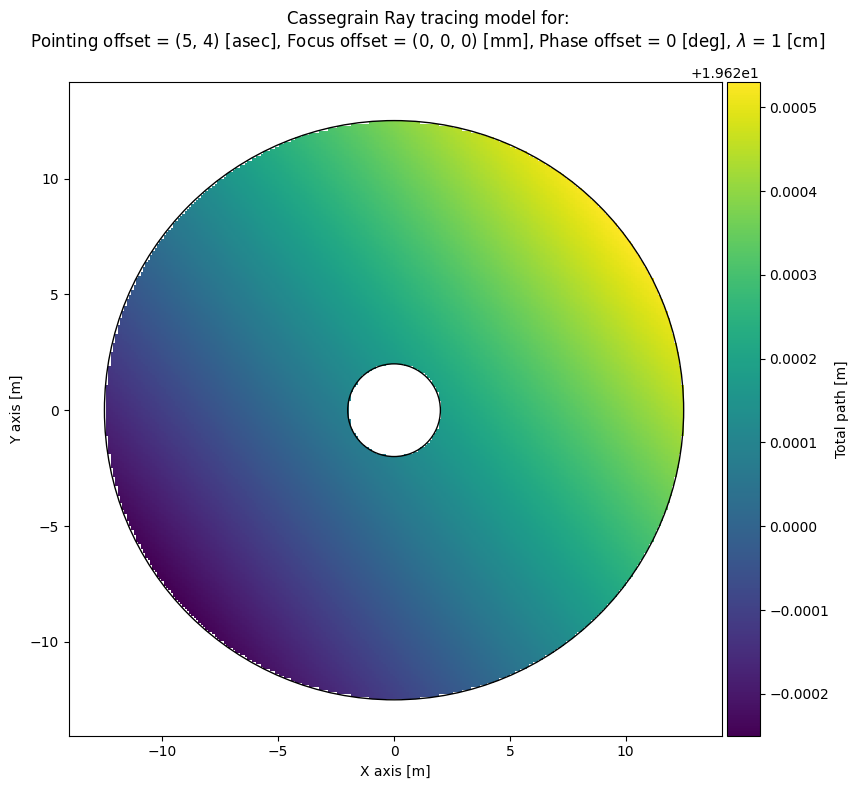

In [6]:
from astrohack import plot_2d_maps_from_rt_xds
plot_2d_maps_from_rt_xds(
        rt_xds_filename = vla_rt_filename,  # Name of the input XDS file with RT results
        keys = ['phase', 'total_path'],     # Keys to be plotted
        rootname = plot_base_names,         # Base name for plot files
        phase_unit = 'deg',                 # Unit for phase plots
        length_unit = 'm',                  # Unit for other available keys
        colormap = 'viridis',               # Colormap to be used in plots
        display = True,                     # Display plots below
        dpi = 300                           # Resolution for the png plots
)

## Radial projection plot

First Simple Telescope RZ projection

[2025-02-11 14:17:43,272]     INFO   toolviper:  Module path: /export/home/figs/vdesouza/work/Holography-1022/astrohack/src/astrohack 
[2025-02-11 14:17:43,309]  WARNING   toolviper:  No rays requested, plot will be a simple Radial projection of the optical system. 


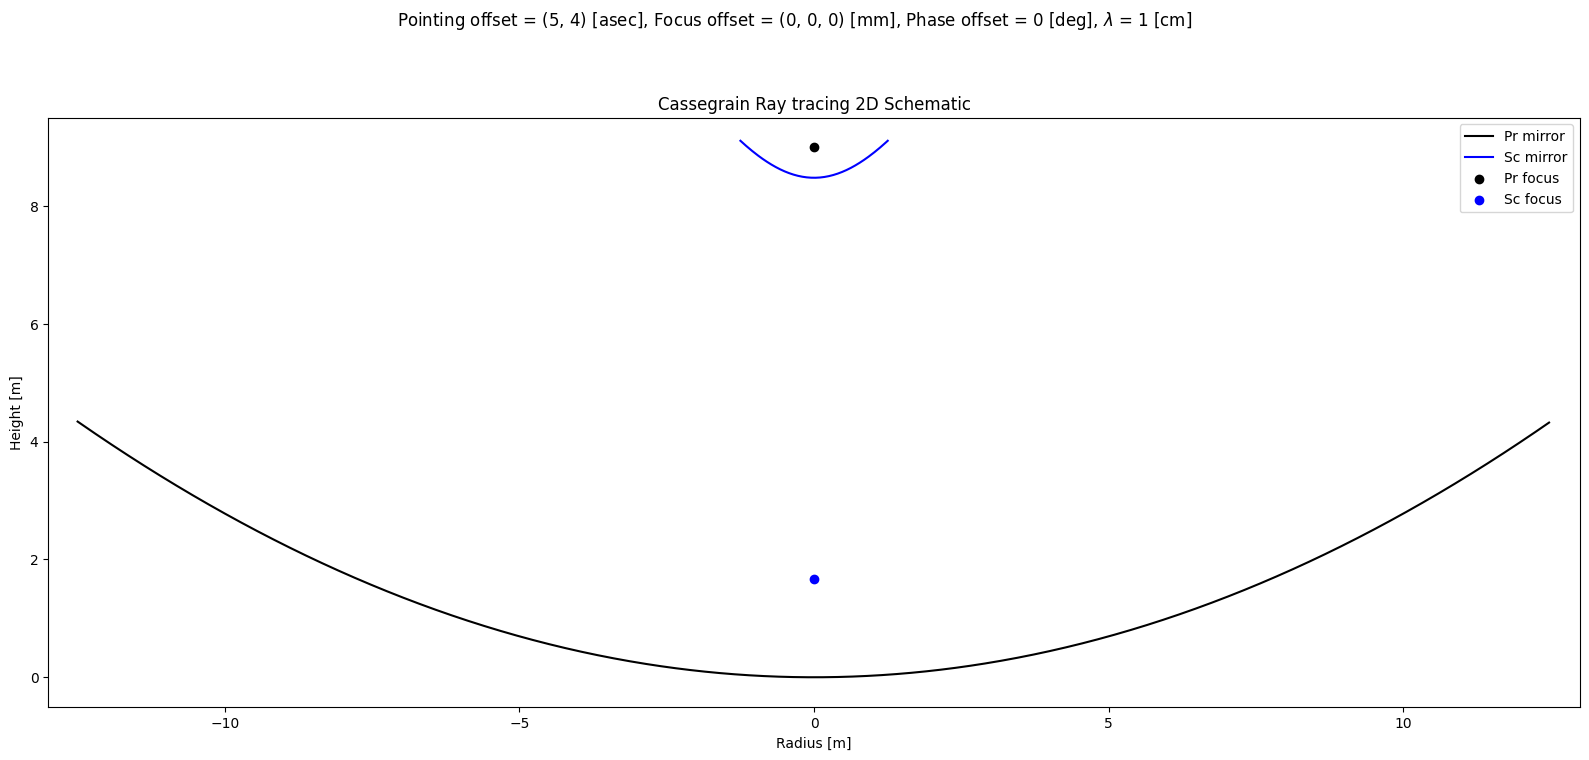

In [7]:
from astrohack import plot_radial_projection_from_rt_xds

plot_radial_projection_from_rt_xds(
        rt_xds_filename = vla_rt_filename,        # RT XDS filename
        plot_filename = plot_base_names+'rz.png', # Name of the file to be saved to disk with the plot
        nrays = 0,                                # No rays plotted here
        display = True,                           # Display plot below
        dpi = 300                                 # Resolution for the png plot
)

Add rays from RT simulation

[2025-02-11 14:17:44,080]     INFO   toolviper:  Module path: /export/home/figs/vdesouza/work/Holography-1022/astrohack/src/astrohack 


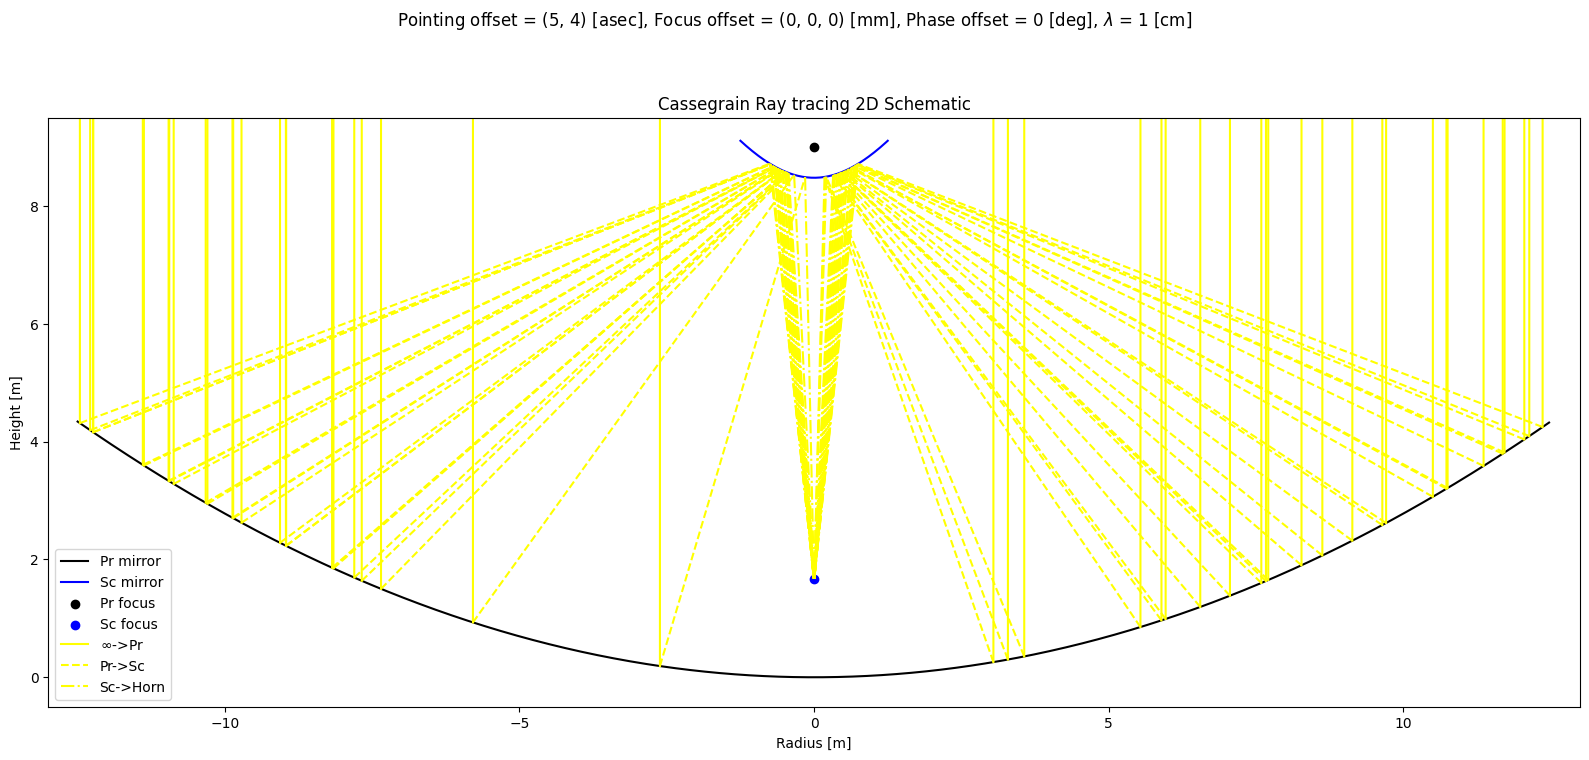

In [8]:
plot_radial_projection_from_rt_xds(
        rt_xds_filename = vla_rt_filename,        # RT XDS filename
        plot_filename = plot_base_names+'rz.png', # Name of the file to be saved to disk with the plot
        nrays = 50,                               # No rays plotted here
        display = True,                           # Display plot below
        dpi = 300                                 # Resolution for the png plot
)

## Comparison to Astrohack's VLA phase fitting
Talk about limts of phase fitting model.
Talk about parameter confusion, focus and phase offset, secondary offsets vs pointing offsets.

[2025-02-11 14:17:45,457]     INFO   toolviper:  Module path: /export/home/figs/vdesouza/work/Holography-1022/astrohack/src/astrohack 
Comparison between input and fitted values
+----------------+-------------+-----------+----------------------+------+
|   Parameter    |    Value    | Reference |      Difference      | unit |
+----------------+-------------+-----------+----------------------+------+
|  Phase offset  | 0.088 ± 0.0 |    0.0    |  0.0882860583723177  | deg  |
| X point offset | 0.051 ± 0.0 |     5     |  -4.948982949182036  | asec |
| Y point offset |  0.05 ± 0.0 |     4     | -3.9503668136497176  | asec |
| X focus offset | -0.21 ± 0.0 |     0     | -0.21027015658099257 |  mm  |
| Y focus offset | -0.17 ± 0.0 |     0     | -0.16778403349878973 |  mm  |
| Z focus offset | 0.057 ± 0.0 |     0     | 0.057348266651310716 |  mm  |
+----------------+-------------+-----------+----------------------+------+




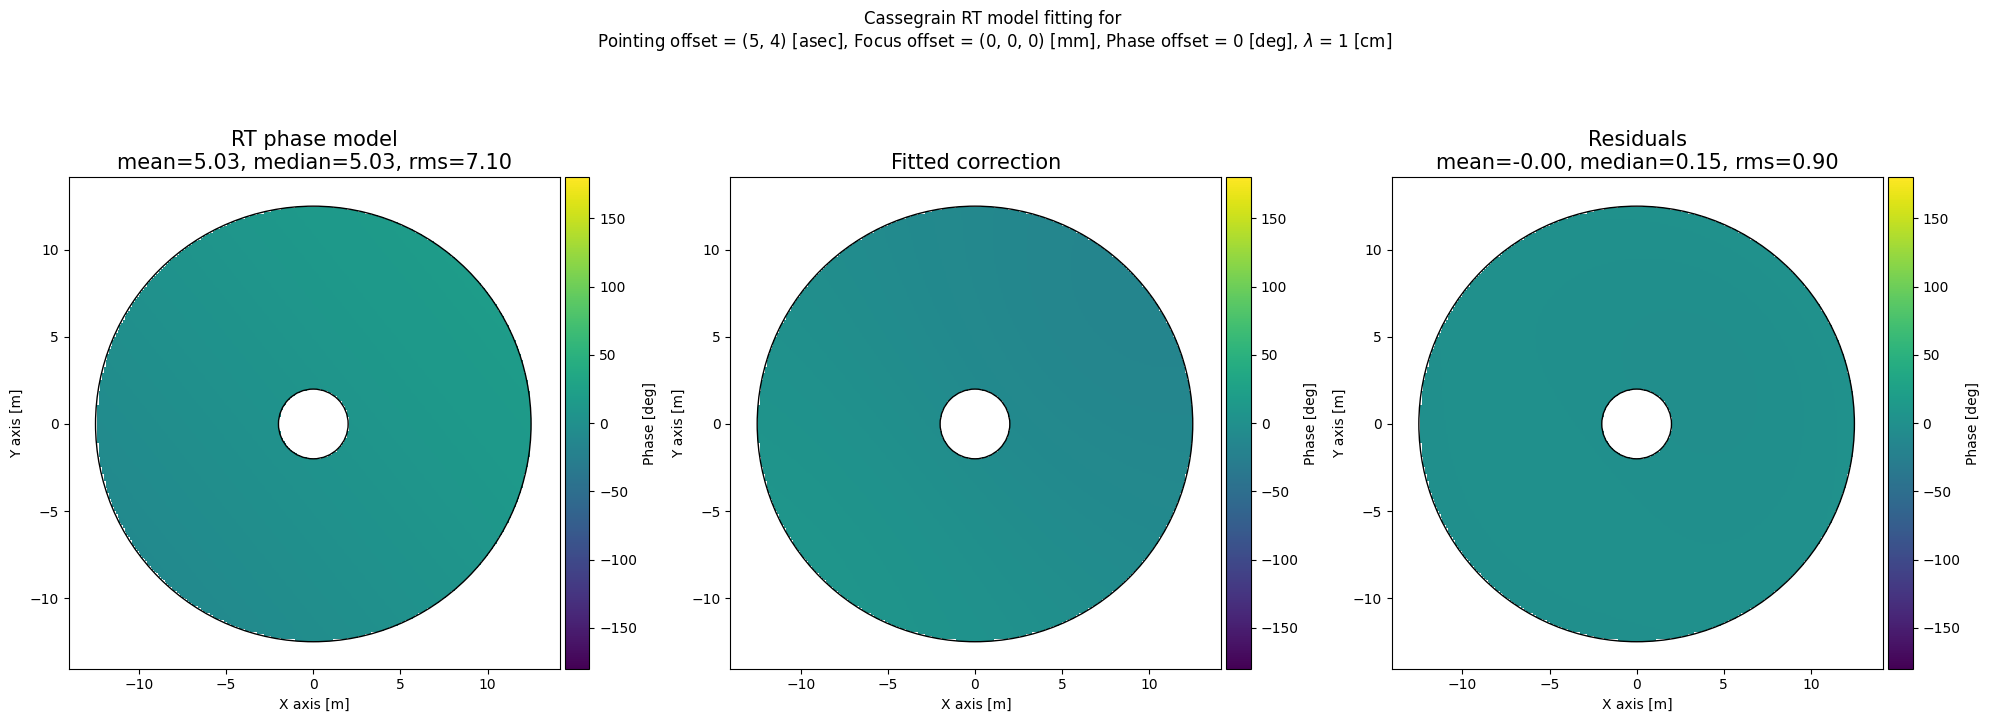

CPU times: user 5.04 s, sys: 999 ms, total: 6.04 s
Wall time: 4.99 s


In [9]:
%%time
from astrohack import apply_holog_phase_fitting_to_rt_xds

apply_holog_phase_fitting_to_rt_xds(
        rt_xds_filename = vla_rt_filename,                  # RT XDS filename
        phase_plot_filename = plot_base_names+'vs-fit.png', # Name of the file to be saved to disk with the phase comparison plot
        fit_pointing_offset = True,                         # Fit pointing offsets
        fit_xy_secondary_offset = True,                     # Fit secondary offsets in the X&Y directions
        fit_focus_offset = True,                            # Fit Z offsets of the secondary
        phase_unit = 'deg',                                 # Unit for phases in plots
        colormap = 'viridis',                               # Colormap for phase plots
        display = True,                                     # Display plot below
        dpi = 300                                           # Resolution for the png plot
)